### Imports

In [367]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 
import math as m 
import os
import sys
import re

from astropy.utils import data
from astropy.wcs import WCS
from astropy.io import fits
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.modeling import models, fitting
from astropy.io import ascii
from astropy.table import Table

#### Optional: Turn off warnings

In [193]:
import warnings
warnings.filterwarnings('ignore') # Turn warnings off

### Gaussian fits

The following block of code produces Gaussian fits for each pixel of N molecule .fits files. 

Change the parameters below for each new source  <br>Change the filename, outfile and numebr of molecuels for each new molecule or set of molecules.

In [194]:
path='/Users/jane/Desktop'   # path to file


def gaussFit(filename, outfile):
    vel_guess = -52  # The initial guess for the centroid velocity of the gaussian fit
    dv_min = 1       # set a minimum acceptable line width
    dv_max = 9       # set a maximum acceptable line width
    snr_min = 2.5    # set a minumum acceptable SNR

    # set the range of pixels in the x direction over which to loop
    min_xpix = 3
    max_xpix = 10

    # set the range of pixels in the y direction over which to loop
    min_ypix = 39
    max_ypix = 46

    # set the velocity range over which to calculate the line integrated intensity
    min_vline = -56
    max_vline = -48

    #set the spectral resolution of the spectra in km/s
    deltaV = 0.4

    #JCMT efficiency at 230 GHz to convert TA* to Tmb
    eta = 0.6
    
    # retrieving the source data and information
    datfile = fits.open(path+'/'+filename)
    cube = SpectralCube.read(datfile)
    wcs = WCS(datfile[0].header) # vel and position info from WCS in header

    # extract the world coordinates of all the pixels using the world property, 
    # which returns the spectral axis then the two positional coordinates in reverse order 
    # (in the same order as the data indices). 
    velo, lat, long  = cube.world[:] 

    # convert the velocity units from m/s (in the fits header) to km/s
    cube2 = cube.with_spectral_unit(u.km / u.s)

    # initialize the arrays to write to an ascii table file at the end
    x, y, glat, glong, vlsr, TA, sigma, fwhm, TAdv, Tmb, Tmbdv = [], [], [], [], [], [], [], [], [], [], []

    # sets an index for the array entries
    n = 0

    # Loop over all pixels in the x and y ranges provided, extract the spectrum at that pixel,
    # fit a gaussian to the spectrum and print and plot the results
    for i in range(min_xpix,max_xpix+1):
        for j in range(min_ypix,max_ypix+1):
            # grab a spectrum at pixel x, y 
            x.append(i)
            y.append(j)
            T = cube2[:, j, i]               # get the intensity/temperature along the spectral axis
            vel = cube2.spectral_axis        # set the velocity axis
            glat.append(lat[0,j,0])          # get the DEC/lat of pixel x/y from the world coordinates
            glong.append(long[0,0,i])        # get the RA/long of pixel x/y from the world coordinates

            # Fit the data using a Gaussian
            g_init = models.Gaussian1D(amplitude=1.0, mean=vel_guess, stddev=1.0)
            fit_g = fitting.LevMarLSQFitter()
            g = fit_g(g_init, vel, T)
            #print(g)

            gT = g.amplitude.value   # Line peak temperature of the gaussian fit  (K)
            gV = g.mean.value        # line centre velocity of the gaussian fit (km/s)
            gS = g.stddev.value      # standard deviation (sigma) width of the gaussian fit (km/s)

            noise = T.std()                      # Calculate the rms noise in the spectrum
            intnoise = deltaV * noise * u.km / u.s  # multiple the noise by the channel width we can calculate the SNR using the intergrated intensity/moment 0
            newgT = gT * u.K                     # give the Gaussian fit temp the units of K                   

            # calculate the integrated intensity of the spectrum over the line
            line = cube2.spectral_slab(min_vline*u.km / u.s, max_vline*u.km / u.s)
            max = line[:,j,i].max()       # calculate the maximum channel height in the region covered by the line
            mom0 = line.moment(order=0)
            mom_line = abs(mom0[j,i])     # extract the moment 0 value fo the desire x, y position/pixel

            # calculate the SNR 
            snr = mom_line/intnoise

            # If the SNR is > some value, the max channel is >  something * noise
            # and the FWHM is > some minimum width and < some maximum width
            # then accept the values of the gaussian fits
            # if not, then we assume that the spectrum is weak, the fit is nonsense and so
            # we set the values to 0 so we know what to ignore in the table
            if snr > snr_min and max > (snr_min*noise) and (2.355*gS) > dv_min and (2.355*gS) < dv_max :
                TA.append(gT)               # Line peak temperature of the gaussian fit  (K)
                vlsr.append(gV)             # line centre velocity of the gaussian fit (km/s)
                sigma.append(gS)            # standard deviation (sigma) width of the gaussian fit (km/s)
                fwhm.append(2.355 * gS)     # Full Width at Half Maximum of the gaussian fit  (km/s)
                Tmb.append(gT/eta)          # Calibrated Line peak temperature of the gaussian fit  (K)
            else:
                TA.append(0)           # Line peak temperature of the gaussian fit  (K)
                vlsr.append(0)         # line centre velocity of the gaussian fit (km/s)
                sigma.append(0)        # standard deviation (sigma) width of the gaussian fit (km/s)
                fwhm.append(0)         # Full Width at Half Maximum of the gaussian fit  (km/s)
                Tmb.append(0)          # Calibrated Line peak temperature of the gaussian fit  (K)

            n += 1    #increment the array index

    # Set the header line, the parameters, and the format of the parameters to 
    # write to an ascii table file        
    out = Table()
    out['Pix_x'] = x
    out['Pix_y'] = y
    out['GLat(deg)'] = glat
    out['GLat(deg)'].info.format = '8.7f'
    out['GLong(deg)'] = glong 
    out['GLong(deg)'].info.format = '8.7f'
    out['TA(K)'] = TA
    out['TA(K)'].info.format = '6.2f'
    out['Tmb(K)'] = Tmb
    out['Tmb(K)'].info.format = '6.2f'
    out['VLSR(km/s)'] = vlsr
    out['VLSR(km/s)'].info.format = '6.2f'
    out['sigma(km/s)'] = sigma
    out['sigma(km/s)'].info.format = '6.2f'
    out['FWHM(km/s)'] = fwhm
    out['FWHM(km/s)'].info.format = '6.2f'
    # Write the gaussian fits of all pixels to a text file 
    ascii.write(out, path+'/'+outfile,  overwrite=True, format='tab')

    print('Gaussian fit results for', filename, 'written to', outfile)
    

In [195]:
gaussFit('s138_HCO+_smo.fits','s138_HCO+_gaussfits.txt') # Gaussian fit for molecule A
gaussFit('s138_HCN_smo.fits','s138_HCN_gaussfits.txt') # Gaussian fit for molecule B

Gaussian fit results for s138_HCO+_smo.fits written to s138_HCO+_gaussfits.txt
Gaussian fit results for s138_HCN_smo.fits written to s138_HCN_gaussfits.txt


### Tkin data retrieval

In [197]:
filename = '/Users/jane/Desktop/s138_temp_regrid.fits'
outfile = '/Users/jane/Desktop/s138_temp_regrid.txt'

# load file, read data, wcs, and header
datfile = fits.open(filename)
dat = datfile[0].data
wcs = WCS(datfile[0].header)

#  y (vert) = 1st position (starting at bottom), x (hor) = 2nd position (starting from left)
xPixT = []
yPixT = []
Tk = []
glatT = []
glongT = []

i = 0
j = 0

# scan through y-axis
for j in range(dat.shape[0]):
    # scan through x-axis 
    for i in range(dat.shape[1]):
        # set the value of the pixel
        zpix = dat[j,i]  # the flux value is found at pixel x, y 
        xPixT.append(i)
        yPixT.append(j)
        Tk.append(zpix)
        gxT, gyT = wcs.wcs_pix2world(i , j , 0) # convert the pixel numbers to WCS coordinates
        glongT.append(gxT)
        glatT.append(gyT)
        

# Set the header line, the parameters, and the format of the parameters to 
# write to an ascii table file        
out = Table()
out['Pix_x'] = xPixT
out['Pix_y'] = yPixT
out['GLat(deg)'] = glatT
out['GLat(deg)'].info.format = '8.5f'
out['GLong(deg)'] = glongT
out['GLong(deg)'].info.format = '8.5f'
out['T(K)'] = Tk
out['T(K)'].info.format = '6.2f'

# Write the values of all pixels to a text file 
ascii.write(out, outfile,  overwrite=True, format='tab')
      
# Convert lists to numpy arrays
xPixT = np.array(xPixT)
yPixT = np.array(yPixT)
Tk = np.array(Tk)

      
M = pd.read_csv('/Users/jane/Desktop/s138_temp_regrid.txt', sep="\t", header=None)
df = pd.DataFrame(data=M)

# put pixels in list and remove header (T denotes full list of all pixels from temperature map)
xPixT = np.array(df[0].tolist())
xPixT = xPixT[1:]
yPixT = np.array(df[1].tolist())
yPixT = yPixT[1:]
Tk = (df[4].tolist())
Tk = Tk[1:]

### Radex column density

The column density will be found using Radex for the specified molecules. <br> As above, if modified appropriately, the cell can be used for any molecule and any number of molecules. 

In [198]:
path='/Users/jane/Desktop'   # path to file

# Molecule A
filename='s138_HCO+_gaussfits.txt'       # input fits file name
outfile = 'radexHCO+.inp' # file name of the radex file
X = pd.read_csv(path+'/'+filename, sep="\t", header=None)
df = pd.DataFrame(data=X)

# put pixel x, y, glat, glong, Tmb, FWHM and VLSR in lists and remove headers
xPixA = np.array(df[0].tolist())
xPixA = xPixA[1:]
yPixA = np.array(df[1].tolist())
yPixA = yPixA[1:]
glatA = np.array(df[2].tolist())
glatA = glatA[1:]
glongA = np.array(df[3].tolist())
glongA = glongA[1:]
tmbA = (df[5].tolist())
tmbA = tmbA[1:]
fwhmA = np.array(df[8].tolist())
fwhmA = fwhmA[1:]
vlsrA = np.array(df[6].tolist())
vlsrA = vlsrA[1:]

# Molecule B
filename='s138_HCN_gaussfits.txt'       # input fits file name
outfile = 'radexHCN.inp' # file name of the radex file
X = pd.read_csv(path+'/'+filename, sep="\t", header=None)
df = pd.DataFrame(data=X)

# put pixel x, y, glat, glong, Tmb, FWHM and VLSR in lists and remove headers
xPixB = np.array(df[0].tolist())
xPixB = xPixB[1:]
yPixB = np.array(df[1].tolist())
yPixB = yPixB[1:]
glatB = np.array(df[2].tolist())
glatB = glatB[1:]
glongB = np.array(df[3].tolist())
glongB = glongB[1:]
tmbB = (df[5].tolist())
tmbB = tmbB[1:]
fwhmB = np.array(df[8].tolist())
fwhmB = fwhmB[1:]
vlsrB = np.array(df[6].tolist())
vlsrB = vlsrB[1:]

#### Running Radex for HCO+ (A) and HCN (B)

In [199]:
# Molecule A

# only keep the pixels from the temperature map data that we have Gaussian fit data for
tk, xx, yy= [], [], []
for i in range(len(xPixA)):
    for j in range(len(xPixT)):
        if ((xPixA[i] == xPixT[j]) and (yPixA[i] == yPixT[j])):
            tk.append(Tk[j])
            xx.append(xPixT[j])
            yy.append(yPixT[j])
           
if (np.all(xPixA != xx) or np.all(yPixA != yy)):
    print('error')

# Run a series of Radex models to retrieve the column density
maxiter = 100
debug   = False

# lists for all new data (omitting null rows)
xPixFull, yPixFull, glongFull, glatFull, colDen, tkFull, tmbFull, vlsrFull, fwhmFull = [], [], [], [], [], [], [], [], []

# loop through all pixels

ran = len(xx)

for i in range(ran):
    
    #only run non-zero rows
    if tmbA[i] != '0.00':
        
        #converting values to floats 
        b = np.asarray(tmbA[i], dtype=float)
        c = np.asarray(fwhmA[i], dtype=float)
        d = np.asarray(tk[i], dtype=float)

        mole = 'HCO+'      #molecule- CAN CHANGE THIS
        freq = 267.6     # frequency GHz
        tkin = d      # Tkin (K)
        nh2 = 1.0e5      # nH2 cm^-3
        tbg = 2.73       # Tbg (K)
        obs = b          # Observed line intensity (K)- Tmb
        dv = c           # FWHM line width km/s
        bw = 0.01       # Bandwidth (GHz)
        tol = 0.01       # tolerance

        radexpath = '/Users/jane/Desktop/Radex/data/'
        extension = '.dat'

        def write_input(cdmol):
            file = open('/Users/jane/Desktop/radexHCO+.inp','w')
            file.write(mole+'.dat\n') 
            file.write('/Users/jane/Desktop/radexHCO+.out\n')
            file.write(str(freq*(1-bw))+' '+str(freq/(1-bw))+'\n')
            file.write(str(tkin)+'\n')
            file.write('1\n')
            file.write('H2\n')
            file.write(str(nh2)+'\n')
            file.write(str(tbg)+'\n')
            file.write(str(cdmol)+'\n')
            file.write(str(dv)+'\n')
            file.write('0\n')
            file.close()

        def read_radex():
            file  = open('/Users/jane/Desktop/radexHCO+.out')
            lines = file.readlines()
            file.close()
            if (lines[-2].split()[-1] != '(erg/cm2/s)'):
                print("Error: Ambiguous line selection. Reduce bandwidth?")
                print("See radex.out for details")
                sys.exit()
            return float(lines[-1].split()[-2])

        # Begin of main program
        oflx = obs*dv
        eps  = 1.0e-20
        iter = 0

        # Starting values of column density and fit residual
        cdmol = 1e12
        ratio = 0

        while (ratio > (1+tol)) or (ratio < (1-tol)) :
            iter += 1
            write_input(cdmol)
            os.system('/Users/jane/Desktop/Radex/bin/radex < /Users/jane/Desktop/radexHCO+.inp > /dev/null')
            mflx  = read_radex()
            if (mflx < eps):
                print("Error: Zero or negative line intensity")
                print("See radex.out for details")
                sys.exit()
            if (debug):
                print("mflx= ",mflx)
            ratio = oflx/mflx
            cdmol = cdmol * ratio
            if (iter > maxiter):
                print("Maximum number of iterations exceeded")
                ratio = 1

        #fmt = "CD %7.2e cm^-2"
        colDen.append(cdmol)
        xPixFull.append(xPixA[i])
        yPixFull.append(yPixA[i])
        glongFull.append(glongA[i])
        glatFull.append(glatA[i])
        tkFull.append(tk[i])
        tmbFull.append(tmbA[i])
        vlsrFull.append(vlsrA[i])
        fwhmFull.append(fwhmA[i])
        
#writing results to table 
outfile = 'columnDenHCO+.txt' # file name of the gaussian fit results
      
out = Table()
out['Pix_x'] = xPixFull
out['Pix_y'] = yPixFull
out['GLat(deg)'] = glatFull
#out['GLat(deg)'].info.format = '8.7f'
out['GLong(deg)'] = glongFull
out['Tk(K)'] = tkFull
out['Tmb(K)'] = tmbFull
#out['Tmb(K)'].info.format = '6.2f'
out['VLSR(km/s)'] = vlsrFull
#out['VLSR(km/s)'].info.format = '6.2f'
out['FWHM(km/s)'] = fwhmFull
#out['FWHM(km/s)'].info.format = '6.2f'
#out['GLong(deg)'].info.format = '8.7f'
out['Col. Den. (cm^-2)'] = colDen
#out['Col. Den. (cm^-2)'].info.format = '6.2f'

# Write the gaussian fits of all pixels to a text file 
ascii.write(out, path+'/'+outfile,  overwrite=True, format='tab')

print('Column density data saved to', outfile)

Column density data saved to columnDenHCO+.txt


In [ ]:
# save column density file as xlsx
X = pd.read_csv('/Users/jane/Desktop/columnDenHCO+.txt', sep="\t", header=None)
df = pd.DataFrame(data=X)
df.to_excel('/Users/jane/Desktop/colDenHCO+.xlsx')

In [474]:
# Molecule B

# only keep the pixels from the temperature map data that we have Gaussian fit data for
tk, xx, yy= [], [], []
for i in range(len(xPixB)):
    for j in range(len(xPixT)):
        if ((xPixB[i] == xPixT[j]) and (yPixB[i] == yPixT[j])):
            tk.append(Tk[j])
            xx.append(xPixT[j])
            yy.append(yPixT[j])
           
if (np.all(xPixB != xx) or np.all(yPixB != yy)):
    print('error')

# Run a series of Radex models to retrieve the column density
maxiter = 100
debug   = False

# lists for all new data (omitting null rows)
xPixFull, yPixFull, glongFull, glatFull, colDen, tkFull, tmbFull, vlsrFull, fwhmFull = [], [], [], [], [], [], [], [], []

# loop through all pixels

ran = len(xx)

for i in range(ran):
    
    #only run non-zero rows
    if tmbB[i] != '0.00':
        
        #converting values to floats 
        b = np.asarray(tmbB[i], dtype=float)
        c = np.asarray(fwhmB[i], dtype=float)
        d = np.asarray(tk[i], dtype=float)

        mole = 'HCN'      #molecule- CAN CHANGE THIS
        freq = 267.6     # frequency GHz
        tkin = d      # Tkin (K)
        nh2 = 1.0e5      # nH2 cm^-3
        tbg = 2.73       # Tbg (K)
        obs = b          # Observed line intensity (K)- Tmb
        dv = c           # FWHM line width km/s
        bw = 0.01       # Bandwidth (GHz)
        tol = 0.01       # tolerance

        radexpath = '/Users/jane/Desktop/Radex/data/'
        extension = '.dat'

        def write_input(cdmol):
            file = open(radexpath+'/'+'radexHCN.inp','w')
            file.write(mole+'.dat\n') 
            file.write(radexpath+'/'+'radexHCN.out\n')
            file.write(str(freq*(1-bw))+' '+str(freq/(1-bw))+'\n')
            file.write(str(tkin)+'\n')
            file.write('1\n')
            file.write('H2\n')
            file.write(str(nh2)+'\n')
            file.write(str(tbg)+'\n')
            file.write(str(cdmol)+'\n')
            file.write(str(dv)+'\n')
            file.write('0\n')
            file.close()

        def read_radex():
            file  = open(radexpath+'/'+'radexHCN.out')
            lines = file.readlines()
            file.close()
            if (lines[-2].split()[-1] != '(erg/cm2/s)'):
                print("Error: Ambiguous line selection. Reduce bandwidth?")
                print("See radex.out for details")
                sys.exit()
            return float(lines[-1].split()[-2])

        # Begin of main program
        oflx = obs*dv
        eps  = 1.0e-20
        iter = 0

        # Starting values of column density and fit residual
        cdmol = 1e12
        ratio = 0

        while (ratio > (1+tol)) or (ratio < (1-tol)) :
            iter += 1
            write_input(cdmol)
            os.system('/Users/jane/Desktop/Radex/bin/radex < /Users/jane/Desktop/radexHCN.inp > /dev/null') # don't use general file path
            mflx  = read_radex()
            if (mflx < eps):
                print("Error: Zero or negative line intensity")
                print("See radex.out for details")
                sys.exit()
            if (debug):
                print("mflx= ",mflx)
            ratio = oflx/mflx
            cdmol = cdmol * ratio
            if (iter > maxiter):
                print("Maximum number of iterations exceeded")
                ratio = 1

        #fmt = "CD %7.2e cm^-2"
        colDen.append(cdmol)
        xPixFull.append(xPixB[i])
        yPixFull.append(yPixB[i])
        glongFull.append(glongB[i])
        glatFull.append(glatB[i])
        tkFull.append(tk[i])
        tmbFull.append(tmbB[i])
        vlsrFull.append(vlsrB[i])
        fwhmFull.append(fwhmB[i])
        
#writing results to table 
outfile = 'columnDenHCN.txt' # file name of the gaussian fit results
      
out = Table()
out['Pix_x'] = xPixFull
out['Pix_y'] = yPixFull
out['GLat(deg)'] = glatFull
#out['GLat(deg)'].info.format = '8.7f'
out['GLong(deg)'] = glongFull
out['Tk(K)'] = tkFull
out['Tmb(K)'] = tmbFull
#out['Tmb(K)'].info.format = '6.2f'
out['VLSR(km/s)'] = vlsrFull
#out['VLSR(km/s)'].info.format = '6.2f'
out['FWHM(km/s)'] = fwhmFull
#out['FWHM(km/s)'].info.format = '6.2f'
#out['GLong(deg)'].info.format = '8.7f'
out['Col. Den. (cm^-2)'] = colDen
#out['Col. Den. (cm^-2)'].info.format = '6.2f'

# Write the gaussian fits of all pixels to a text file 
ascii.write(out, path+'/'+outfile,  overwrite=True, format='tab')

print('Column density data saved to', outfile)

Maximum number of iterations exceeded
Maximum number of iterations exceeded
Maximum number of iterations exceeded
Maximum number of iterations exceeded
Column density data saved to columnDenHCN.txt


In [ ]:
# save column density file as xlsx
X = pd.read_csv(path+'/'+'columnDenHCN.txt', sep="\t", header=None)
df = pd.DataFrame(data=X)
df.to_excel(path+'/'+'colDenHCN.xlsx')

### Plotting density maps

In [473]:
# import HCN and HCO+ col. den. data files

# "A" denotes the first molecule (here HCO+)
A = pd.read_csv(path+'/'+'columnDenHCO+.txt', sep="\t", header=None)
dataA = pd.DataFrame(data=A)

# create lists for coordinates and column density (omitting the first row/header)
xPixA = np.array(dataA[0].tolist())
xPixA = xPixA[1:]
yPixA = np.array(dataA[1].tolist())
yPixA = yPixA[1:]
glatA = np.array(dataA[2].tolist())
glatA = glatA[1:]
glongA = np.array(dataA[3].tolist())
glongA = glongA[1:]
nA = np.array(dataA[8].tolist())
nA = nA[1:]
nAfloat = nA.astype(float) # float needed later on

# "B" denotes the first molecule (usually HCN)
B = pd.read_csv(path+'/'+'columnDenHCN.txt', sep="\t", header=None)
dataB = pd.DataFrame(data=B)

xPixB = np.array(dataB[0].tolist())
xPixB = xPixB[1:]
yPixB = np.array(dataB[1].tolist())
yPixB = yPixB[1:]
glatB = np.array(dataB[2].tolist())
glatB = glatB[1:]
glongB = np.array(dataB[3].tolist())
glongB = glongB[1:]
nB = np.array(dataB[8].tolist())
nB = nB[1:]
nBfloat = nB.astype(float) # float needed later on

# convert round glat, glong to arrays of floats and round to 4 decimals to be compared in following for loop
glatA = np.round(glatA.astype(float), 3)
glatB = np.round(glatB.astype(float), 3)
glongA = np.round(glongA.astype(float), 3)
glongB = np.round(glongB.astype(float), 3)

# ensure glat,glong coordinates match xPix, yPix between molecules
for i in range(len(xPixA)):
    for j in range(len(xPixB)):
        if ((xPixA[i] == xPixB[j]) and (yPixA[i] == yPixB[j])):
            if ((glatA[i] != glatB[j]) or (glongA[i] != glongB[j])):
                print('Error- molecule coordinates not alligned')

# If no errors print, use coordinates from either molecule for both (here HCO+ is used)


# Eliminating doubles from coordinate lists
# loop searches for coordinate pair and appends if it is not already in the list

def shorten(listLong):
    x = len(listLong)
    temp = []
    for i in range(x):
        if (listLong[i] not in temp):
            temp.append(listLong[i])
            temp.sort() # reorders list from smallest to largest
    return(temp)

glatAshort = shorten(glatA)
glatBshort = shorten(glatB)
glongAshort = shorten(glongA)
glongBshort = shorten(glongB)

In [437]:

# <= for smaller array range, >= for larger array range
# regardless of range choice, density ratio will only populate areas both ranges cover
# here HCO+ has larger range

if (len(glatAshort) <= len(glatBshort)):
    lenglat = len(glatAshort)
    savedglat = glatAshort
else:
    lenglat = len(glatBshort)
    savedglat = glatBshort

if (len(glongAshort) <= len(glongBshort)):
    lenglong = len(glongAshort)
    savedglong = glongAshort
else:
    lenglong = len(glongBshort)
    savedglong = glongBshort
    
largeArray = np.zeros([lenglat,lenglong]) # array of desired size of zeros for largest span of coordinates

largeCoord = []
for i in range(len(savedglat)):
    for j in range(len(savedglong)):
        largeCoord.append([savedglat[i], savedglong[j]])
#largeCoord = largeCoord[::-1]        

# ratio of column density will be found for pixels that contain data for both molecules

smallCoord = []
for i in range(len(glatA)):
    for j in range(len(glatB)):
        if ((glatA[i] == glatB[j]) and (glongA[i] == glongB[j])):
            ratio = (nBfloat[j]/nAfloat[i])
            lst = [[glatA[i], glongA[i]], ratio]
            smallCoord.append(lst)                     # coordinates of non-zero ratio
            
smallCoord = sorted(smallCoord, key=lambda tup: tup[0], reverse=True)            

# populating large array with dnesity ratios from small array

for i in range(len(smallCoord)):
    for j in range(len(largeCoord)):
        if (smallCoord[i][0] == largeCoord[j]):
            largeArray[m.floor(j/len(savedglong))][j%len(savedglong)] = smallCoord[i][1]

# finding bounds of glat and glong coordinates
# works only if list values are ascending- here they are from the shorten() function applied above
glatMin = savedglat[0]
glatMax = savedglat[-1]
glongMin = savedglong[0]
glongMax = savedglong[-1]
          
glataxis = np.asarray(savedglat, dtype='float64')
glongaxis = np.asarray(savedglong, dtype='float64')

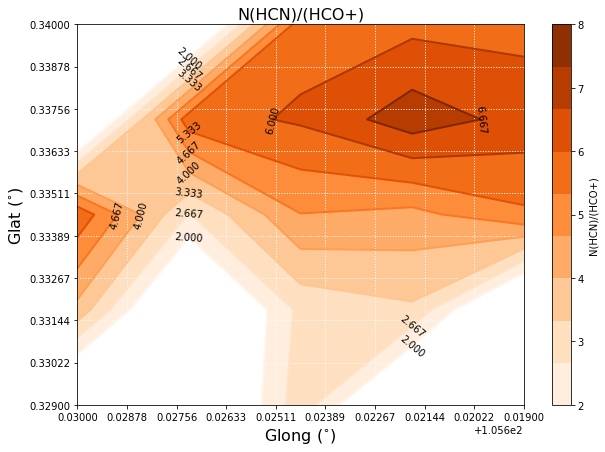

In [472]:
# contour plot

u = np.linspace(glatMin, glatMax, num=len(savedglat))
v = np.linspace(glongMin, glongMax, num=len(savedglong))
breaksFill = np.linspace(2,8,10)
breaksBar = np.linspace(2,8,7)
breaksLines = np.linspace(2,8,10)
breaksLevels = np.linspace(2,8,10)
breaksy = np.linspace(glatMin, glatMax, 10)
breaksx = np.linspace(glongMin, glongMax, 10)

# filled contour
fig = plt.figure(figsize=(10,7), facecolor='white')
CS1 = plt.contourf(v, u, largeArray, breaksFill, cmap='Oranges')

# colour bar
cbar = plt.colorbar(ticks=breaksBar, orientation='vertical')
cbar.set_label('N(HCN)/(HCO+)')

# contour lines
CS2 = plt.contour(v, u, largeArray, breaksLines, cmap='Oranges', linewidths=2) 
plt.clabel(CS2, colors='k', inline=False)

# labels
plt.xlabel("Glong ($^{\circ}$)", fontsize=16)
plt.ylabel("Glat ($^{\circ}$)", fontsize=16)
plt.title('N(HCN)/(HCO+)', size=16)

# axes
plt.yticks(breaksy)
plt.xticks(breaksx)
plt.gca().invert_xaxis()

plt.grid(color='white', ls='dotted', lw=1)

plt.show()

In [ ]:
# Turn warnings back on
warnings.filterwarnings('default')

Floris van der Tak, R. Plume